# Business Problem:
A group of customers were given an offer in person that they can get a loan at discounted rate and
processing fee will be waived off. A pilot campaign was conducted to get response from customers
whether they are interested in taking out a loan or not. Response was recorded and data was collected.

### Need to Do

- [x] Build a model to predict whether customers will be interested in taking out a loan or not.
- [x] Identifying features which are most important
- [x] In case of black box models e.g. Random forest use SHAP, LIME to figure out features affecting the target variable
- [x] Try Unsupervised clustering models
- [ ] Generate synthetic data for model.
- [x] Approaching a customer has costs involved with it, hence find the profitable segments so that more customized marketing can be done.
- [ ] Need to write inferences what is going on
- [x] Bucketing Age and SCR

Variables involved: `Customer_id`, `Age`, `Gender`, `Balance`, `Occupation`, `No of Credit transaction`, `SCR`, `Holding period`

> ## Understanding Variables


- `Holding Period` (How long the customer is able to hold the money in his account.. So, if they have some existing expenses like a loan EMI or any other monthly expense which gets deducted, usually the first week of every month, hence it makes the balance in the account lower during initial days of the month itself.Higher the holding period, more stable their money is in the account.)

- `SCR` SCR is a score given to a customer for a particular product ( in this case loan ) based on certain parameters, to know whether how likely that customer is to buy that product.. so, higher the score, higher the probability, the customer will buy it.. ###SCR propensity of a customer to respond to a digital marketing


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc, plot_roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE


import xgboost as xgb

In [2]:
# from pandasgui import show

In [3]:
data = pd.read_csv('Model_data.csv')
# show(data)

In [4]:
data.Balance = data.Balance.astype('int32') #Truncating decimals

In [5]:
data.head()

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period
0,0,41,M,91519,SELF-EMP,38,926,15
1,0,52,M,117288,SAL,17,768,13
2,0,31,F,259827,SENP,8,816,5
3,0,45,F,26677,PROF,14,353,18
4,0,39,F,43440,SENP,1,751,31


In [6]:
data.Balance.describe()

count    2.000000e+04
mean     1.461808e+05
std      1.698125e+05
min      0.000000e+00
25%      2.373650e+04
50%      7.975550e+04
75%      2.173100e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [7]:
data.shape

(20000, 8)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Target          20000 non-null  int64 
 1   Age             20000 non-null  int64 
 2   Gender          20000 non-null  object
 3   Balance         20000 non-null  int32 
 4   Occupation      20000 non-null  object
 5   No_OF_CR_TXNS   20000 non-null  int64 
 6   SCR             20000 non-null  int64 
 7   Holding_Period  20000 non-null  int64 
dtypes: int32(1), int64(5), object(2)
memory usage: 1.1+ MB


`Gender` and `Occupation` are categorical varibles stored as object type

## EDA

No Strong correlations measured except for mild ones in `Holding_period` and other variables

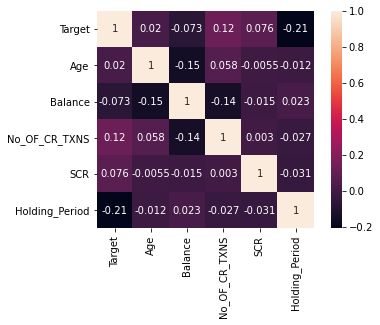

In [9]:
sns.heatmap(data.corr(), annot=True, square=True) # No strong correlations seen overall
plt.show()

In [10]:
sns.pairplot(data, hue='Target')
plt.show()

KeyboardInterrupt: 

In [ ]:
sns.countplot(x = data.Gender)
plt.show()

In [ ]:
data.Gender.unique()

In [ ]:
data.Occupation.unique()

In [ ]:
data.Gender.value_counts()

In [ ]:
data.drop(data.Gender[data.Gender== 'O'].index, axis = 0, inplace= True) # Removed 196 rows with `Gender` = 'O'

In [ ]:
data.shape

In [17]:
data.Balance.describe()

count    1.980400e+04
mean     1.465609e+05
std      1.694485e+05
min      0.000000e+00
25%      2.399900e+04
50%      8.035100e+04
75%      2.183090e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [18]:
# sns.histplot(data.Age)

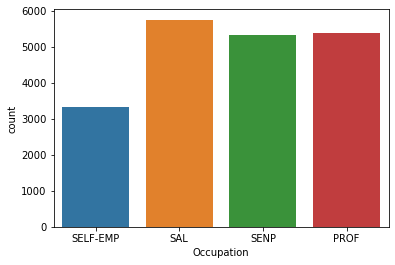

In [19]:
sns.countplot(x = data.Occupation)

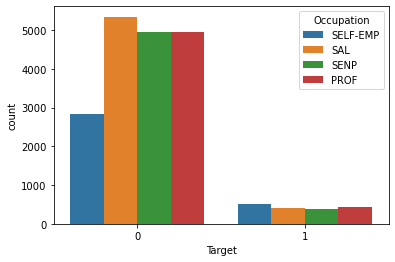

In [20]:
sns.countplot(x=data.Target, hue=data.Occupation) ## Self employed are much more likely to take loans

C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


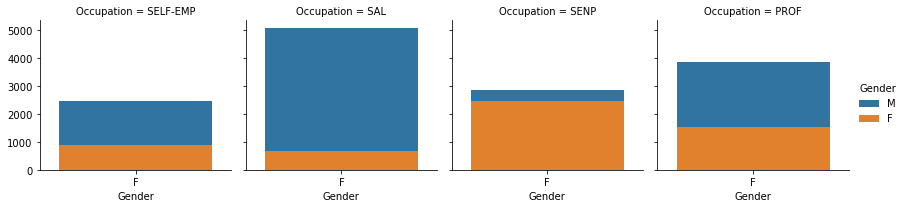

In [21]:
g = sns.FacetGrid(data, col='Occupation', hue="Gender")
plt.grid(True)
g.map(sns.countplot, "Gender", alpha=1)
g.add_legend()
plt.grid((False))

--------------------------

In [22]:
# sns.histplot(data.No_OF_CR_TXNS)

In [23]:
data.No_OF_CR_TXNS.describe()

count    19804.000000
mean        16.563169
std         12.928214
min          0.000000
25%          7.000000
50%         13.000000
75%         21.000000
max         50.000000
Name: No_OF_CR_TXNS, dtype: float64

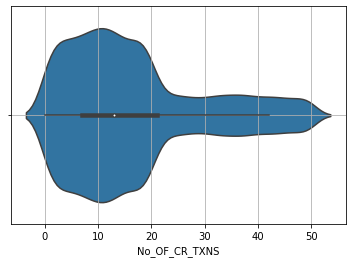

In [24]:
sns.violinplot(x=data.No_OF_CR_TXNS)
plt.grid(True)

In [25]:
# len(data[data.No_OF_CR_TXNS==0].index)

In [26]:
# data.drop(index=data[data.No_OF_CR_TXNS==0].index, axis=0)

------------------

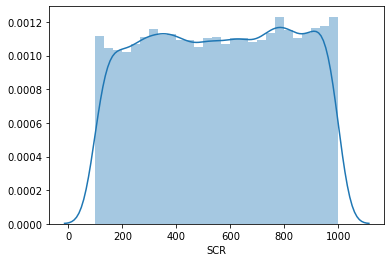

In [27]:
# sns.displot(data.SCR, kind = 'kde')
sns.distplot(data.SCR)
plt.show()

In [28]:
data.SCR.describe()

count    19804.000000
mean       557.115987
std        260.562729
min        100.000000
25%        332.000000
50%        560.500000
75%        784.250000
max        999.000000
Name: SCR, dtype: float64

In [29]:
# sns.histplot(data.Holding_Period)

In [30]:
data3 = data

##### End of Exploratory Data Analysis
-----------
----------

> ### Create a function for easy report printing

In [11]:
# A class for pretty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
# function for validation on test data   
def classification_report(y_true, y_prediction, type_of_data='Enter Over/Under/Original sampled', type_of_classifier='ClassifierName'):
    """Print Classification report"""
    
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    
    print('Classification Report on Testing Data:\n'+ color.BOLD + type_of_data, 'data\n'+color.END+color.RED+color.BOLD+type_of_classifier,'Classifier'+color.END+color.END)
    print()
    print('---------------------------------------')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1 score: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print('---------------------------------------')
    print()


# A function for cross-validation report    
def cross_val_report(classifier, train_data, train_label, cv=10, scoring=['recall','precision', 'f1','accuracy']):
    
    score = cross_validate(classifier, train_data, train_label, cv=cv, scoring= scoring)
    recall = np.mean(score['test_recall'])
    precision = np.mean(score['test_precision'])
    f1 = np.mean(score['test_f1'])
    accuracy= np.mean(score['test_accuracy'])
    print('Cross Validation Report')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print()
    print("*Mean values presented")
    print('---------------------------------------')

**Create the first set of training and test data on imbalanced data**

In [12]:
df = pd.get_dummies(data, columns=['Gender','Occupation'], drop_first = True)
df.head()

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_M,Gender_O,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP
0,0,41,91519,38,926,15,1,0,0,1,0
1,0,52,117288,17,768,13,1,0,1,0,0
2,0,31,259827,8,816,5,0,0,0,0,1
3,0,45,26677,14,353,18,0,0,0,0,0
4,0,39,43440,1,751,31,0,0,0,0,1


>**Creating a model with Original Unbalanced data and measuring metrics**

In [13]:
X_original = df.iloc[:,1:]
y_original = df.iloc[:,0]

In [14]:
X_original

,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_M,Gender_O,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP
0,41,91519,38,926,15,1,0,0,1,0
1,52,117288,17,768,13,1,0,1,0,0
2,31,259827,8,816,5,0,0,0,0,1
3,45,26677,14,353,18,0,0,0,0,0
4,39,43440,1,751,31,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
19995,23,67612,20,164,27,0,0,0,0,1
19996,34,472365,8,124,1,0,0,0,0,0
19997,42,100642,4,263,1,1,0,1,0,0
19998,36,29950,10,345,31,1,0,0,0,1


In [15]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original,y_original, shuffle = ['True'], stratify=y_original)

## DecisionTreeClassifier - Original Data

Classification Report on Testing Data:
Original data
Decision Tree Classifier

---------------------------------------
Recall: 0.09237875288683603
Precision: 0.5
F1 score: 0.15594541910331383
Accuracy: 0.9134
---------------------------------------



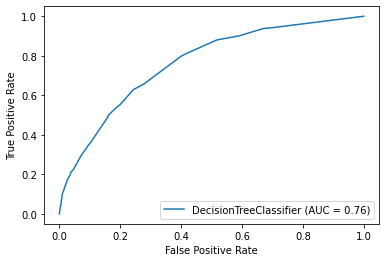

In [16]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train_orig, y_train_orig)
y_prediction_orig = clf.predict(X_test_orig)
classification_report(y_test_orig, y_prediction_orig, 'Original', 'Decision Tree')
plot_roc_curve(clf, X_test_orig, y_test_orig)
plt.show()
# cross_val_report(clf, y_test_orig,y_under_prediction.reshape(1,-1))

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
confusion_matrix(y_test_orig, y_prediction_orig)

array([[4527,   40],
       [ 393,   40]], dtype=int64)

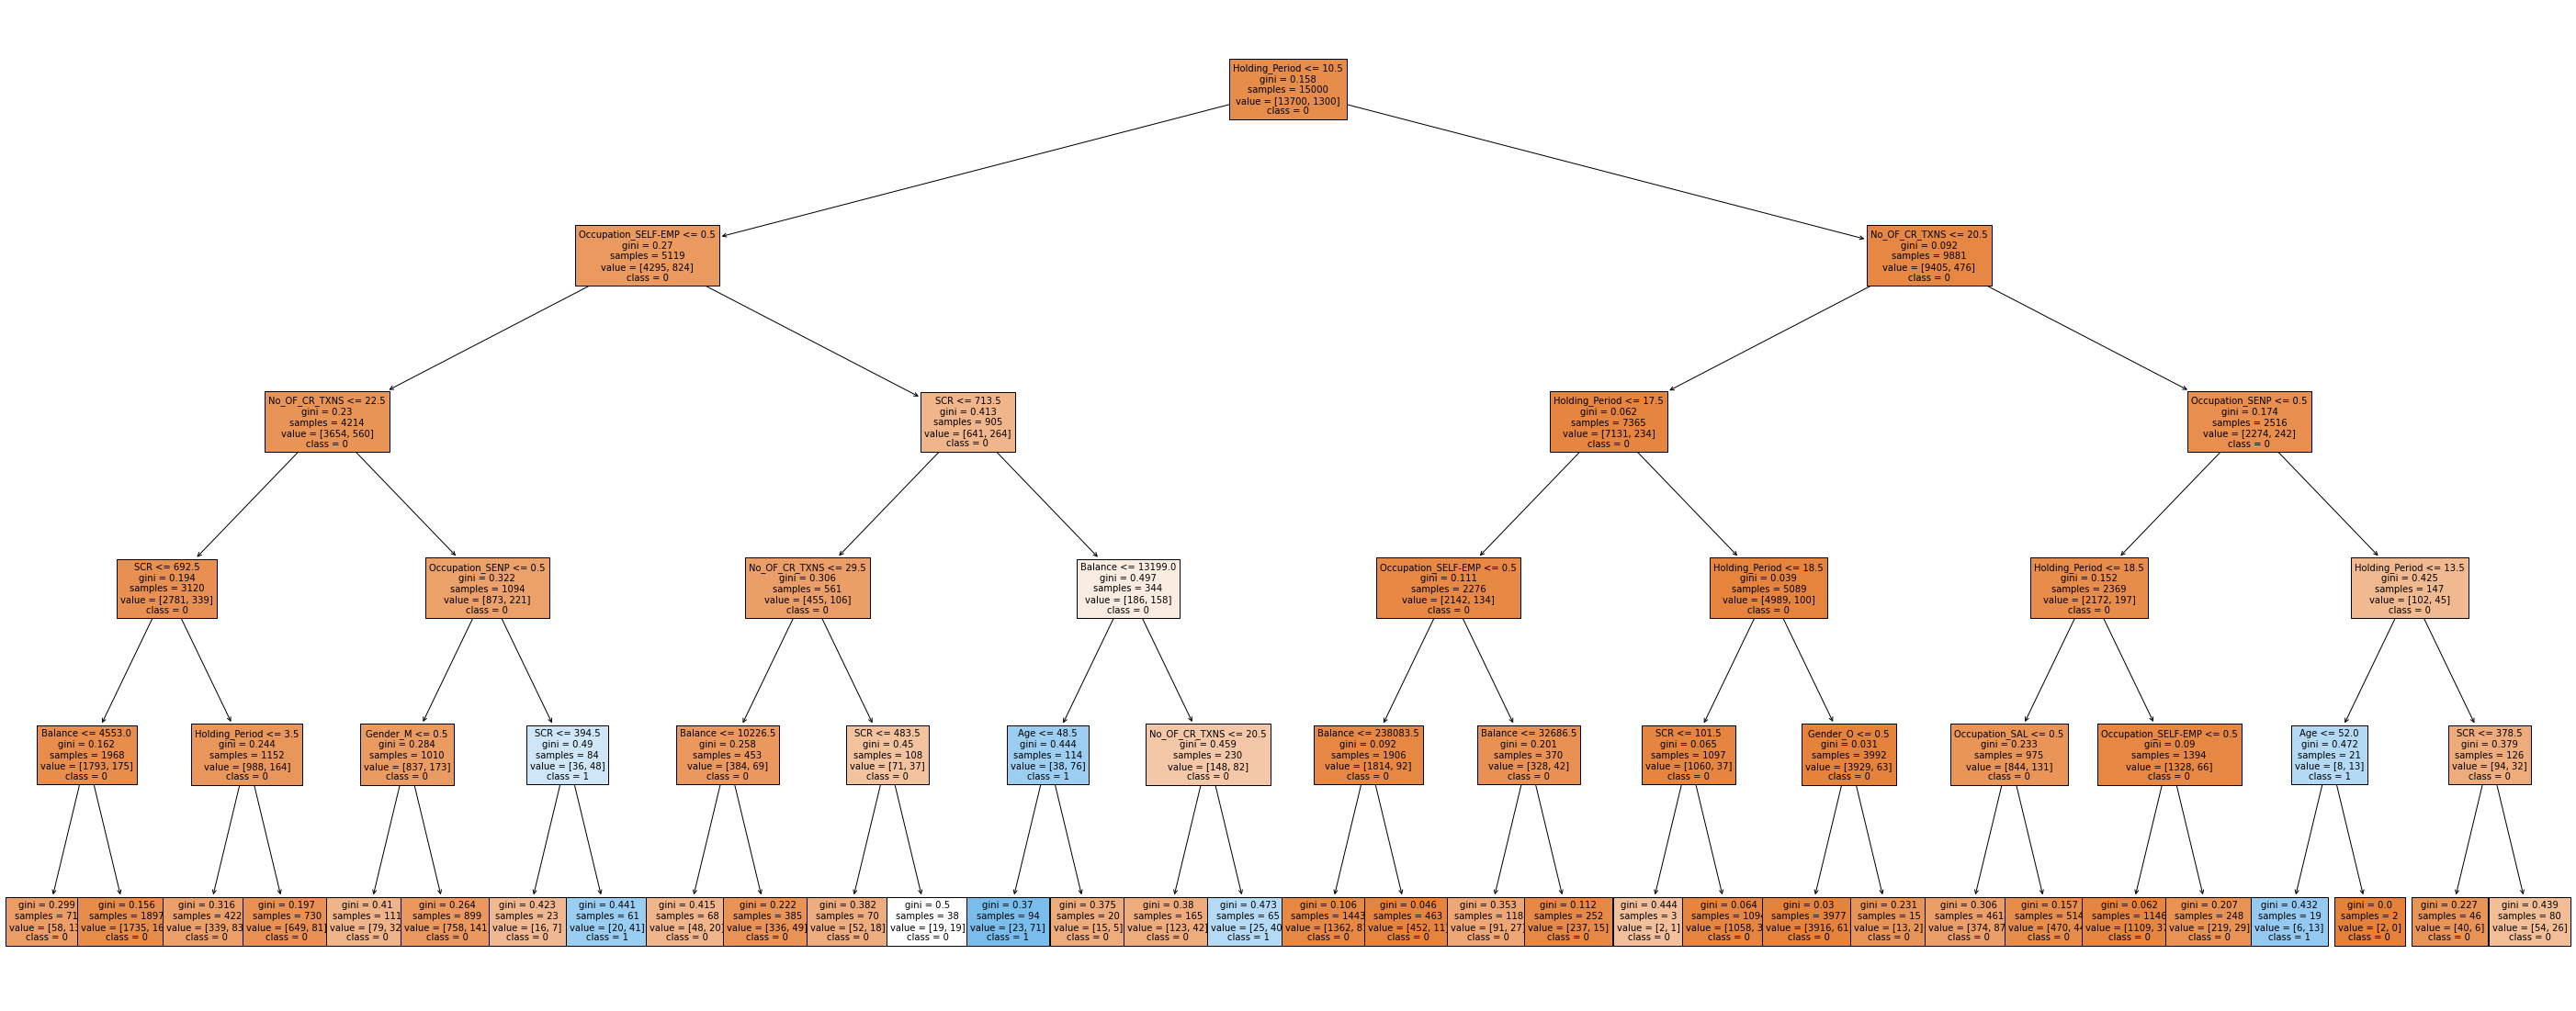

In [21]:
fig = plt.figure(figsize=(50,20))
_ = plot_tree(clf, 
                   feature_names=list(X_original.columns),  
                   class_names=['0','1'],
                   filled=True, fontsize=10)
plt.savefig("decoriginal.png")


In [25]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):

# 	'''
# 	Outputs a decision tree model as a Python function
	
# 	Parameters:
# 	-----------
# 	tree: decision tree model
# 		The decision tree to represent as a function
# 	feature_names: list
# 		The feature names of the dataset used for building the decision tree
# 	'''

	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)

In [28]:
tree_to_code(data, list(data.feature_names))

AttributeError: 'DataFrame' object has no attribute 'feature_names'

## High confidence and correct, but low prediction count

-----------

>**Create undersampled data and fit a model**

In [39]:
X_under_train, y_under_train = NearMiss().fit_resample(X_train_orig, y_train_orig)

In [40]:
data[data.Target==1].shape

(1709, 8)

In [41]:
X_under_train.shape, y_under_train.shape

((2564, 9), (2564,))

## DecisionTreeClassifier - UnderSampled Data

Classification Report on Testing Data:
Undersampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.7494145199063232
Precision: 0.08961075329039485
F1 score: 0.16008004002001003
Accuracy: 0.3217531811755201
---------------------------------------



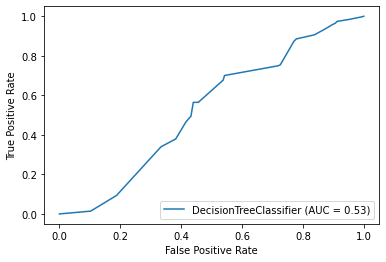

In [42]:
clf_under_sampled = DecisionTreeClassifier(max_depth = 5)
clf_under_sampled.fit(X_under_train, y_under_train)
y_under_prediction = clf_under_sampled.predict(X_test_orig)
classification_report(y_test_orig,y_under_prediction, 'Undersampled', 'Decision Tree')
plot_roc_curve(clf_under_sampled, X_test_orig, y_test_orig)

In [43]:
confusion_matrix(y_test_orig, y_under_prediction)

array([[1273, 3251],
       [ 107,  320]], dtype=int64)

Makes much more predictions, but s = .097

Similar as above

In [44]:
# cross_val_report(clf_under_sampled, y_test_orig,y_under_prediction)

## crossval here causes unbalanced split

In [45]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(clf_under_sampled, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

--------------------

> Model on  an oversampled dataset

In [46]:
X_over_train, y_over_train = SMOTE().fit_resample(X_train_orig, y_train_orig)

## DecisionTreeClassifier - OverSampled Data

Classification Report on Testing Data:
Oversampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.5409836065573771
Precision: 0.1642958748221906
F1 score: 0.2520458265139116
Accuracy: 0.7230862452029893
---------------------------------------



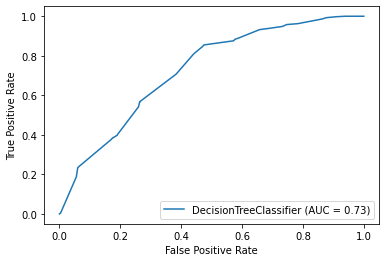

In [47]:
clf_over_sampled = DecisionTreeClassifier(max_depth = 5)
clf_over_sampled.fit(X_over_train, y_over_train)
y_over_predict = clf_over_sampled.predict(X_test_orig)
classification_report(y_test_orig, y_over_predict, 'Oversampled', 'Decision Tree')
plot_roc_curve(clf_over_sampled, X_test_orig, y_test_orig)

In [175]:
confusion_matrix(y_test_orig, y_over_predict)

array([[3349, 1175],
       [ 196,  231]], dtype=int64)

In [49]:
s = 0.22805017103762829 ## higher predictions and better confidence

In [50]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(clf_over_sampled, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

---------------

In [51]:
print("Original:     "+color.BOLD+ "X_original,y_original"+color.END+"::  X_train_orig, X_test_orig, y_train_orig, y_test_orig")
print()
print("Undersampled:"+color.BOLD+ " X_under, y_under"+color.END+"     ::  X_under_train, y_under_train")
print()
print("Oversampled:"+color.BOLD+ "  X_over, y_over"+color.END+"       ::  X_over_train, y_over_train")

Original:     X_original,y_original::  X_train_orig, X_test_orig, y_train_orig, y_test_orig

Undersampled: X_under, y_under     ::  X_under_train, y_under_train

Oversampled:  X_over, y_over       ::  X_over_train, y_over_train


The above datasets can be better sampled by adjusting hyper-parameters of NearMiss and SMOTE, or other methods of sampling could be used

-----------
-----------

## SVM Classifiers applied

*SVC fails to fit on original dataset, possibly because of unbalance*

In [52]:
# clf_svc0 = SVC()
# clf_svc0.fit(X_under_train, y_under_train)
# y_predict = clf_svc0.predict(X_test_orig)
# classification_report(y_test_orig, y_predict, 'Undersampled', 'SVM')
# plot_roc_curve(clf_svc0, X_test_orig, y_test_orig)
# cross_val_report(clf_svc0, X_under_train, y_under_train)

In [53]:
# confusion_matrix(y_test_orig, y_over_predict)

In [54]:
# %%time
# # Will take LONG Time for Training
# clf_svc1 = SVC()
# clf_svc1.fit(X_over_train, y_over_train)
# y_predict = clf_svc1.predict(X_test_orig)
# classification_report(y_test_orig, y_predict, 'Oversampled', 'SVM')
# plot_roc_curve(clf_svc1, X_test_orig, y_test_orig)
# cross_val_report(clf_svc1, X_under_train, y_under_train)

-------------
--------------------

## KNN Classifier - Original Data

Classification Report on Testing Data:
Original data
KNN Classifier

---------------------------------------
Recall: 0.06557377049180328
Precision: 0.27722772277227725
F1 score: 0.10606060606060605
Accuracy: 0.9046657240961422
---------------------------------------

Cross Validation Report
Recall: 0.5974503391472868
Precision: 0.688131418697419
F1: 0.6362214285010015
Accuracy: 0.659148528696498

*Mean values presented
---------------------------------------


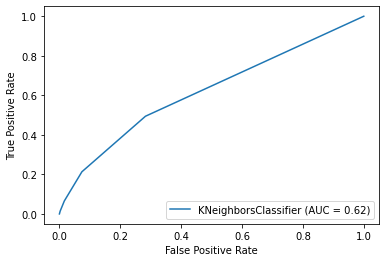

In [55]:
clf_KNN0 = KNeighborsClassifier()
clf_KNN0.fit(X_train_orig, y_train_orig)
y_predict= clf_KNN0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'KNN')
plot_roc_curve(clf_KNN0, X_test_orig, y_test_orig)
cross_val_report(clf_KNN0, X_under_train, y_under_train)

In [174]:
confusion_matrix(y_test_orig, y_predict)

array([[3362, 1162],
       [ 227,  200]], dtype=int64)

In [57]:
349/3050

0.11442622950819673

-----------

## KNN Classifier - Undersampled Data

Classification Report on Testing Data:
Undersampled data
KNN Classifier

---------------------------------------
Recall: 0.7330210772833724
Precision: 0.0795425667090216
F1 score: 0.14351215038972948
Accuracy: 0.24540496869319328
---------------------------------------

Cross Validation Report
Recall: 0.5974503391472868
Precision: 0.688131418697419
F1: 0.6362214285010015
Accuracy: 0.659148528696498

*Mean values presented
---------------------------------------


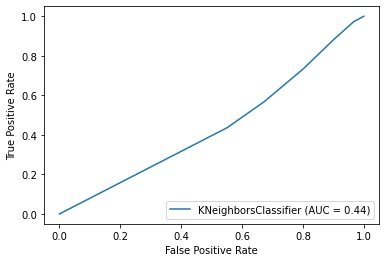

In [58]:
clf_KNN1 = KNeighborsClassifier()
clf_KNN1.fit(X_under_train, y_under_train)
y_predict= clf_KNN1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'KNN')
plot_roc_curve(clf_KNN1, X_test_orig, y_test_orig)
cross_val_report(clf_KNN1, X_under_train, y_under_train)

In [59]:
confusion_matrix(y_test_orig, y_predict)

array([[ 902, 3622],
       [ 114,  313]], dtype=int64)

In [60]:
311/3596

0.08648498331479422

----------
----------

## Random Forest Classifier - Original Data

Classification Report on Testing Data:
Original data
Random Forest Classifier

---------------------------------------
Recall: 0.10772833723653395
Precision: 0.647887323943662
F1 score: 0.18473895582329317
Accuracy: 0.9179963643708342
---------------------------------------

Cross Validation Report
Recall: 0.7877846414728682
Precision: 0.782529906253037
F1: 0.7839993740247758
Accuracy: 0.7831225680933852

*Mean values presented
---------------------------------------


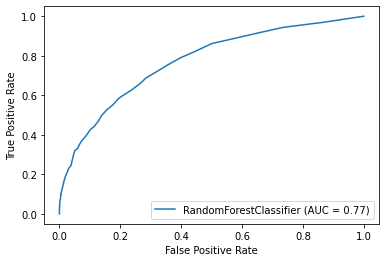

In [61]:
clf_rf0 = RandomForestClassifier()
clf_rf0.fit(X_train_orig, y_train_orig)
y_predict= clf_rf0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Random Forest')
plot_roc_curve(clf_rf0, X_test_orig, y_test_orig)
cross_val_report(clf_rf0, X_under_train, y_under_train)

In [62]:
confusion_matrix(y_test_orig, y_predict)

array([[4499,   25],
       [ 381,   46]], dtype=int64)

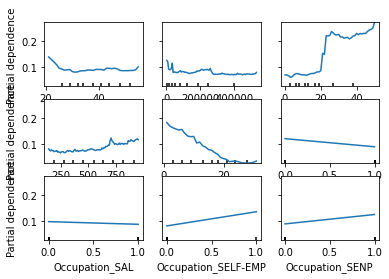

In [63]:
plot_partial_dependence(clf_rf0, X_test_orig, X_test_orig.columns)

-------------

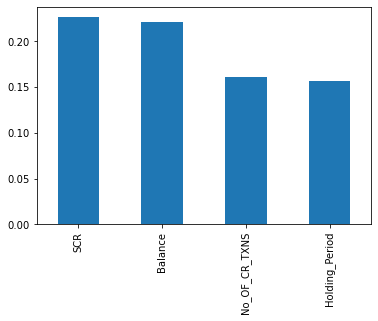

In [64]:
(pd.Series(clf_rf0.feature_importances_, index=X_test_orig.columns)
   .nlargest(4)
   .plot(kind='bar'))

## RFE Implementation

In [71]:
from sklearn.feature_selection import RFE

In [72]:
rfe = RFE(RandomForestClassifier(), n_features_to_select=4)
rfe = rfe.fit(X_over_train, y_over_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True False False False False]
[2 1 1 1 1 5 3 6 4]


In [74]:
categorical_features_indices = np.where(X_train_orig.dtypes != np.float)[0]

In [77]:
categorical_features_indices

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

## RandomForest Classifier - Undersampled Data

In [75]:
X_train_orig.columns

Index(['Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period', 'Gender_M',
       'Occupation_SAL', 'Occupation_SELF-EMP', 'Occupation_SENP'],
      dtype='object')

Classification Report on Testing Data:
Undersampled data
Random Forest Classifier

---------------------------------------
Recall: 0.7985948477751756
Precision: 0.10305228165608946
F1 score: 0.18254817987152033
Accuracy: 0.38315491819834374
---------------------------------------

Cross Validation Report
Recall: 0.7823401162790697
Precision: 0.7865515133741212
F1: 0.7831718508128864
Accuracy: 0.7835086332684825

*Mean values presented
---------------------------------------


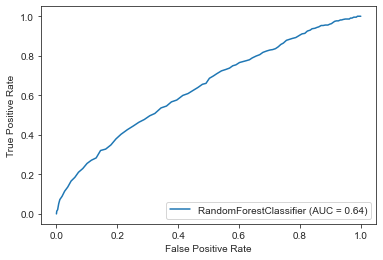

In [201]:
clf_rf1 = RandomForestClassifier()
clf_rf1.fit(X_under_train, y_under_train)
y_predict= clf_rf1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Random Forest')
plot_roc_curve(clf_rf1, X_test_orig, y_test_orig)
cross_val_report(clf_rf1, X_under_train, y_under_train)

In [202]:
confusion_matrix(y_test_orig, y_predict)

array([[1556, 2968],
       [  86,  341]], dtype=int64)

-------------

## RandomForest Classifier - Oversampled Data

In [79]:
clf_rf2 = RandomForestClassifier()

Classification Report on Testing Data:
Oversampled data
Random Forest Classifier

---------------------------------------
Recall: 0.8032786885245902
Precision: 0.10266387309188865
F1 score: 0.18205944798301488
Accuracy: 0.37749949505150476
---------------------------------------

Cross Validation Report
Recall: 0.787796753875969
Precision: 0.7841495204317607
F1: 0.7847961387557582
Accuracy: 0.7835010335603113

*Mean values presented
---------------------------------------


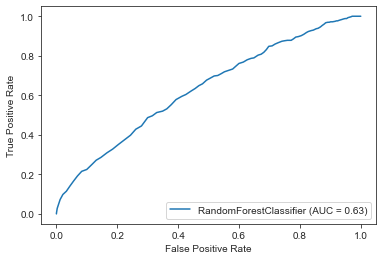

In [203]:
clf_rf2.fit(X_under_train, y_under_train)
y_predict= clf_rf2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Random Forest')
plot_roc_curve(clf_rf2, X_test_orig, y_test_orig)
cross_val_report(clf_rf2, X_under_train, y_under_train)

In [207]:
confusion_matrix(y_test_orig, y_predict)

array([[4520,    4],
       [ 426,    1]], dtype=int64)

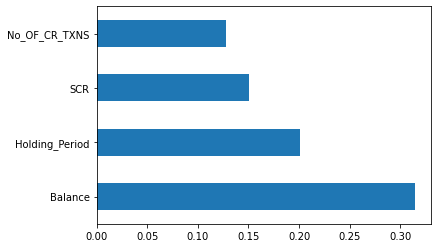

In [81]:
(pd.Series(clf_rf2.feature_importances_, index=X_test_orig.columns)
   .nlargest(4)
   .plot(kind='barh'))

----------
----------------

## Logistic Regression - Original Data

In [86]:
from sklearn.linear_model import LogisticRegression

Classification Report on Testing Data:
Original data
Logistic Regression Classifier

---------------------------------------
Recall: 0.00234192037470726
Precision: 0.2
F1 score: 0.004629629629629629
Accuracy: 0.9131488588164007
---------------------------------------

Cross Validation Report
Recall: 0.6856589147286821
Precision: 0.6644064428410642
F1: 0.673519479537181
Accuracy: 0.6677361989299611

*Mean values presented
---------------------------------------


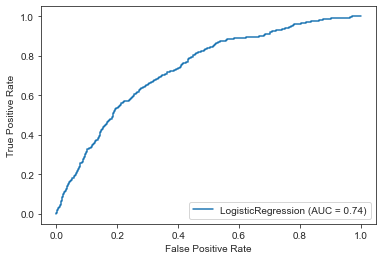

In [208]:
lr0 = LogisticRegression(max_iter=1000)
lr0.fit(X_train_orig, y_train_orig)
y_predict= lr0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Logistic Regression')
plot_roc_curve(lr0, X_test_orig, y_test_orig)
cross_val_report(lr0, X_under_train, y_under_train)

In [210]:
confusion_matrix(y_test_orig, y_predict)

array([[4520,    4],
       [ 426,    1]], dtype=int64)

## Logistic Regression - Undersampled Data

Classification Report on Testing Data:
Undersampled data
Logistic Regression Classifier

---------------------------------------
Recall: 0.6955503512880562
Precision: 0.1412940057088487
F1 score: 0.23487544483985764
Accuracy: 0.6091698646738033
---------------------------------------

Cross Validation Report
Recall: 0.6856589147286821
Precision: 0.6644064428410642
F1: 0.673519479537181
Accuracy: 0.6677361989299611

*Mean values presented
---------------------------------------


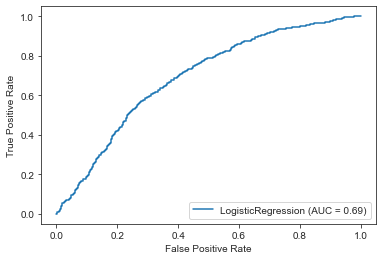

In [211]:
lr1 = LogisticRegression(max_iter=100)
lr1.fit(X_under_train, y_under_train)
y_predict= lr1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Logistic Regression')
plot_roc_curve(lr1, X_test_orig, y_test_orig)
cross_val_report(lr1, X_under_train, y_under_train)

In [212]:
confusion_matrix(y_test_orig, y_predict)

array([[2719, 1805],
       [ 130,  297]], dtype=int64)

## Logistic Regression - Oversampled Data

Classification Report on Testing Data:
Oversampled data
Logistic Regression Classifier

---------------------------------------
Recall: 0.6721311475409836
Precision: 0.17257967528562837
F1 score: 0.27464114832535885
Accuracy: 0.6937992324782872
---------------------------------------

Cross Validation Report
Recall: 0.6856589147286821
Precision: 0.6644064428410642
F1: 0.673519479537181
Accuracy: 0.6677361989299611

*Mean values presented
---------------------------------------


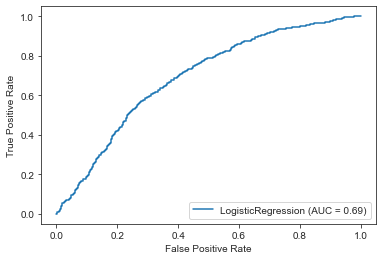

In [213]:
lr2 = LogisticRegression(max_iter=100)
lr2.fit(X_over_train, y_over_train)
y_predict= lr2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Logistic Regression')
plot_roc_curve(lr1, X_test_orig, y_test_orig)
cross_val_report(lr1, X_under_train, y_under_train)

In [214]:
confusion_matrix(y_test_orig, y_predict)

array([[3148, 1376],
       [ 140,  287]], dtype=int64)

------
------

## KNN Classifier - Oversampled Data

Classification Report on Testing Data:
Oversampled data
KNN Classifier

---------------------------------------
Recall: 0.468384074941452
Precision: 0.14684287812041116
F1 score: 0.22358859698155395
Accuracy: 0.7194506160371642
---------------------------------------

Cross Validation Report
Recall: 0.5974503391472868
Precision: 0.688131418697419
F1: 0.6362214285010015
Accuracy: 0.659148528696498

*Mean values presented
---------------------------------------


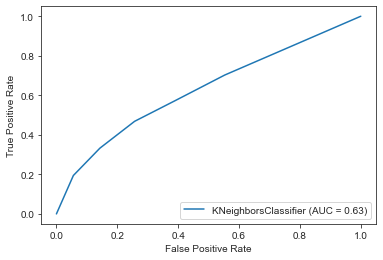

In [215]:
clf_KNN2 = KNeighborsClassifier()
clf_KNN2.fit(X_over_train, y_over_train)
y_predict= clf_KNN2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'KNN')
plot_roc_curve(clf_KNN2, X_test_orig, y_test_orig)
cross_val_report(clf_KNN2, X_under_train, y_under_train)

In [216]:
confusion_matrix(y_test_orig, y_predict)

array([[3362, 1162],
       [ 227,  200]], dtype=int64)

**_Segment the customer with prob >90, 80>prob>90, 70>prob>80, 60>prob>70 and so on_**

In [91]:
predict_prob = clf_KNN2.predict_proba(X_test_orig)
predict_prob.shape
# print more significant digits here

(4951, 2)

In [92]:
# predict_prob

In [93]:
predictions = pd.DataFrame(predict_prob, columns=[0, 'PredictionProb'])

In [94]:
# predictions.head()

In [95]:
predictions_prob = predictions.drop(0, axis=1)

In [96]:
y = pd.DataFrame(y_test_orig, columns = ['Target'])
y = y.reset_index(drop=True)

In [97]:
error = y.Target- predictions_prob.PredictionProb

In [98]:
# This series indicate the error, closer to zero values mean better prediction
# positive mean that my model should have predicted loan taker, but did not
# negative means that model should have predicted NOT a loan taker, but did predict as such

## Target - Probablity

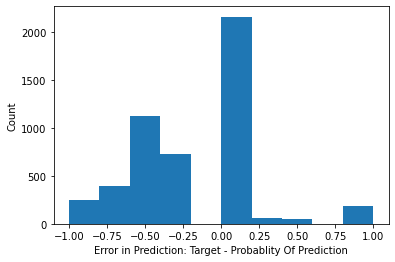

In [100]:
plt.hist(error)
plt.xlabel('Error in Prediction: Target - Probablity Of Prediction')
plt.ylabel("Count")
plt.show()

## PRE-BUCKETING VISUALIZATIONS FOR INFERENCES

### SCR Vs Occupation Vs Target

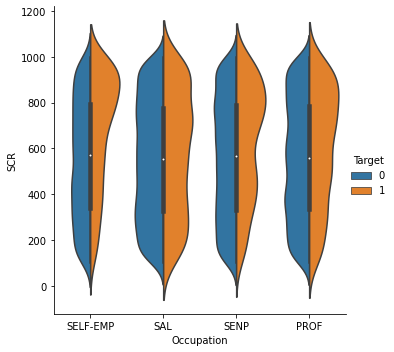

In [101]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, kind = "violin", split = True)
plt.show()

### SCR Vs Occupation Vs Target

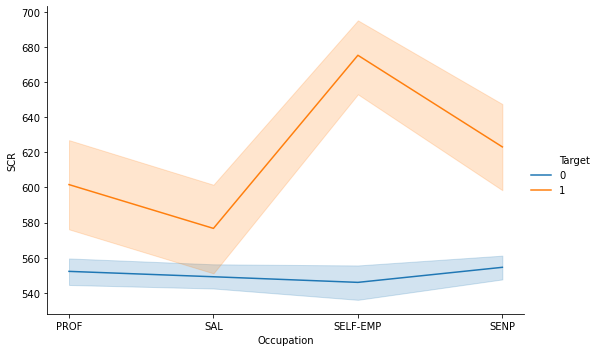

In [102]:
sns.relplot(x="Occupation", y="SCR", hue = "Target",data=data, aspect=1.5, kind = "line")
plt.show()

### SCR Vs Occupation Vs Target

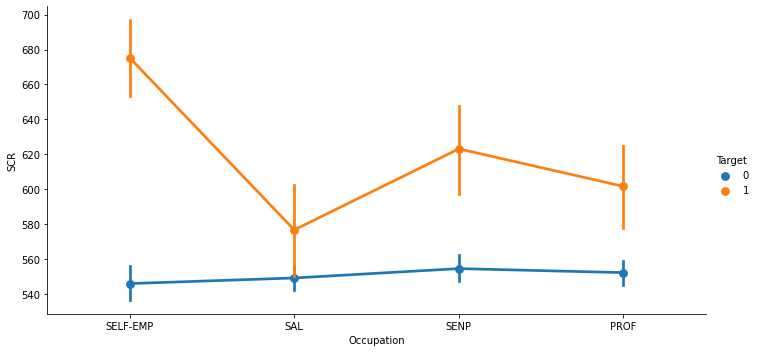

In [103]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, aspect=2.0, kind = "point")
plt.show()

In [107]:
data1 = data.copy()

## Bucketing for AGE values

In [108]:
data1['Ageb'] = pd.qcut(data['Age'], q=4)

In [109]:
data1.head()

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period,Ageb
0,0,41,M,91519,SELF-EMP,38,926,15,"(38.0, 46.0]"
1,0,52,M,117288,SAL,17,768,13,"(46.0, 55.0]"
2,0,31,F,259827,SENP,8,816,5,"(30.0, 38.0]"
3,0,45,F,26677,PROF,14,353,18,"(38.0, 46.0]"
4,0,39,F,43440,SENP,1,751,31,"(38.0, 46.0]"


In [110]:
data1.Ageb.value_counts()

(30.0, 38.0]      5188
(20.999, 30.0]    5136
(46.0, 55.0]      4936
(38.0, 46.0]      4544
Name: Ageb, dtype: int64

In [111]:
data1.dtypes

Target               int64
Age                  int64
Gender              object
Balance              int32
Occupation          object
No_OF_CR_TXNS        int64
SCR                  int64
Holding_Period       int64
Ageb              category
dtype: object

In [112]:
data1.Ageb

0          (38.0, 46.0]
1          (46.0, 55.0]
2          (30.0, 38.0]
3          (38.0, 46.0]
4          (38.0, 46.0]
              ...      
19995    (20.999, 30.0]
19996      (30.0, 38.0]
19997      (38.0, 46.0]
19998      (30.0, 38.0]
19999      (30.0, 38.0]
Name: Ageb, Length: 19804, dtype: category
Categories (4, interval[float64]): [(20.999, 30.0] < (30.0, 38.0] < (38.0, 46.0] < (46.0, 55.0]]

In [113]:
data1.head(5)

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period,Ageb
0,0,41,M,91519,SELF-EMP,38,926,15,"(38.0, 46.0]"
1,0,52,M,117288,SAL,17,768,13,"(46.0, 55.0]"
2,0,31,F,259827,SENP,8,816,5,"(30.0, 38.0]"
3,0,45,F,26677,PROF,14,353,18,"(38.0, 46.0]"
4,0,39,F,43440,SENP,1,751,31,"(38.0, 46.0]"


In [114]:
# sns.pairplot(data1, hue='Target')

In [115]:
data1 = pd.get_dummies(data1)

In [116]:
data1.head(2)

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_F,Gender_M,Occupation_PROF,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP,"Ageb_(20.999, 30.0]","Ageb_(30.0, 38.0]","Ageb_(38.0, 46.0]","Ageb_(46.0, 55.0]"
0,0,41,91519,38,926,15,0,1,0,0,1,0,0,0,1,0
1,0,52,117288,17,768,13,0,1,0,1,0,0,0,0,0,1


In [117]:
data2 = data1.copy()

In [118]:
data1.columns

Index(['Target', 'Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period',
       'Gender_F', 'Gender_M', 'Occupation_PROF', 'Occupation_SAL',
       'Occupation_SELF-EMP', 'Occupation_SENP', 'Ageb_(20.999, 30.0]',
       'Ageb_(30.0, 38.0]', 'Ageb_(38.0, 46.0]', 'Ageb_(46.0, 55.0]'],
      dtype='object')

In [119]:
cols = ['Ageb_(30.0, 38.0]', 'Ageb_(20.999, 30.0]','Ageb_(46.0, 55.0]','Ageb_(38.0, 46.0]']

def func1(x):
    if x ==1:
        return 1
def func2(x):
    if x ==1:
        return 2

def func3(x):
    if x ==1:
        return 3

def func4(x):
    if x ==1:
        return 4


data1['age_d'] = data1['Ageb_(30.0, 38.0]'].apply(func1)
data1['age_d'] = data1['Ageb_(20.999, 30.0]'].apply(func2)
data1['age_d'] = data1['Ageb_(46.0, 55.0]'].apply(func3)
data1['age_d'] = data1['Ageb_(38.0, 46.0]'].apply(func4)

In [121]:
for ind, row in data1.iterrows():
    if row['Ageb_(20.999, 30.0]'] ==1:
        data1.loc[ind, 'age_d'] = 1
    elif row['Ageb_(30.0, 38.0]'] ==1:
        data1.loc[ind, 'age_d'] = 2
    elif row['Ageb_(38.0, 46.0]'] ==1:
        data1.loc[ind, 'age_d'] = 3
    elif row['Ageb_(46.0, 55.0]'] ==1:
        data1.loc[ind, 'age_d'] = 4

In [122]:
data1.age_d.value_counts()

2.0    5188
1.0    5136
4.0    4936
3.0    4544
Name: age_d, dtype: int64

In [123]:
data1.age_d = data1.age_d.astype('int32')

In [124]:
data1.head()

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_F,Gender_M,Occupation_PROF,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP,"Ageb_(20.999, 30.0]","Ageb_(30.0, 38.0]","Ageb_(38.0, 46.0]","Ageb_(46.0, 55.0]",age_d
0,0,41,91519,38,926,15,0,1,0,0,1,0,0,0,1,0,3
1,0,52,117288,17,768,13,0,1,0,1,0,0,0,0,0,1,4
2,0,31,259827,8,816,5,1,0,0,0,0,1,0,1,0,0,2
3,0,45,26677,14,353,18,1,0,1,0,0,0,0,0,1,0,3
4,0,39,43440,1,751,31,1,0,0,0,0,1,0,0,1,0,3


## POST-BUCKETING VISUALIZATIONS FOR INFERENCES

### SCR Vs Age-Category Vs Target

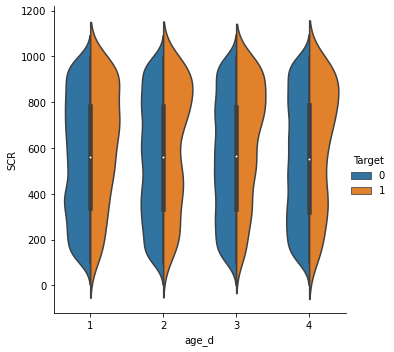

In [125]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

### SCR Vs Age-Categories Vs Target

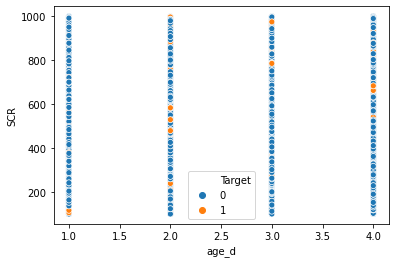

In [128]:
sns.scatterplot(x='age_d', y="SCR", hue = "Target",data=data1,)
plt.show()

### SCR Vs Age-Category Vs Target

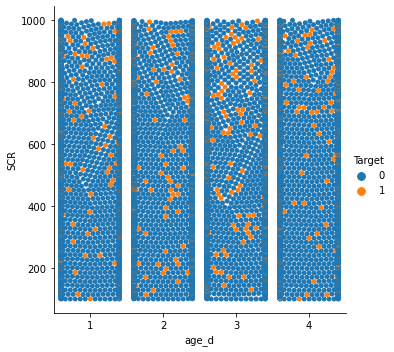

In [129]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, kind = "swarm")
plt.show()

In [130]:
sns.set_style('ticks')

### SCR Vs Age-Category Vs Target

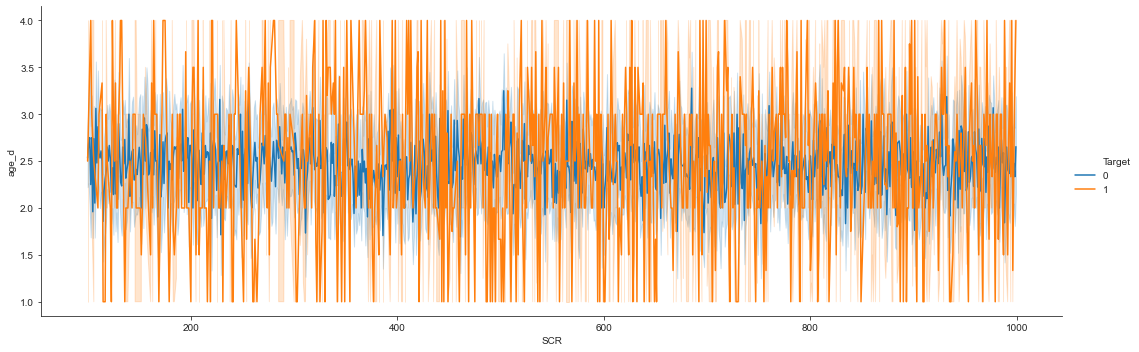

In [131]:
g = sns.relplot(x="SCR", y="age_d", hue = "Target",data=data1, aspect=3, kind = "line")
# g.figure.set_size_inches(18.5, 10.5)
# sns.despine()

## BUCKETING SCR & HOLDING PERIODS

In [140]:
data1['SCRb'] = pd.qcut(data['SCR'], q=5)

In [141]:
data1.SCRb.value_counts()

(99.999, 288.0]    3987
(468.0, 651.0]     3964
(826.0, 999.0]     3956
(651.0, 826.0]     3952
(288.0, 468.0]     3945
Name: SCRb, dtype: int64

In [142]:
data1['HPB'] = pd.qcut(data['Holding_Period'], q=4)

In [143]:
data1.HPB.value_counts()

(0.999, 8.0]    5519
(16.0, 23.0]    4998
(8.0, 16.0]     4791
(23.0, 31.0]    4496
Name: HPB, dtype: int64

In [144]:
data1.head()

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_F,Gender_M,Occupation_PROF,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP,"Ageb_(20.999, 30.0]","Ageb_(30.0, 38.0]","Ageb_(38.0, 46.0]","Ageb_(46.0, 55.0]",age_d,SCRb,HPB
0,0,41,91519,38,926,15,0,1,0,0,1,0,0,0,1,0,3,"(826.0, 999.0]","(8.0, 16.0]"
1,0,52,117288,17,768,13,0,1,0,1,0,0,0,0,0,1,4,"(651.0, 826.0]","(8.0, 16.0]"
2,0,31,259827,8,816,5,1,0,0,0,0,1,0,1,0,0,2,"(651.0, 826.0]","(0.999, 8.0]"
3,0,45,26677,14,353,18,1,0,1,0,0,0,0,0,1,0,3,"(288.0, 468.0]","(16.0, 23.0]"
4,0,39,43440,1,751,31,1,0,0,0,0,1,0,0,1,0,3,"(651.0, 826.0]","(23.0, 31.0]"


### SCR-Bucketed Vs Age-Category Vs Target

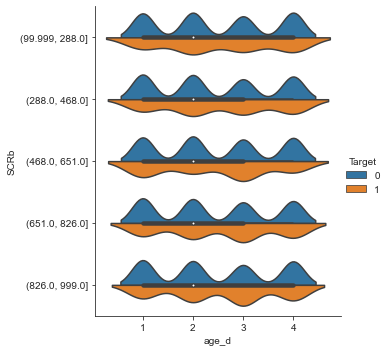

In [145]:
sns.catplot(x="age_d", y="SCRb", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

### Holding Period Bucketed Vs Age-Category Vs Target

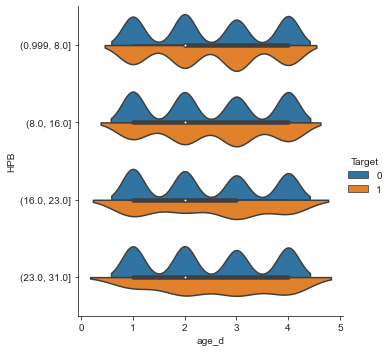

In [146]:
sns.catplot(x="age_d", y="HPB", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

### Pair-Plot on Bucketed Data

C:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg,

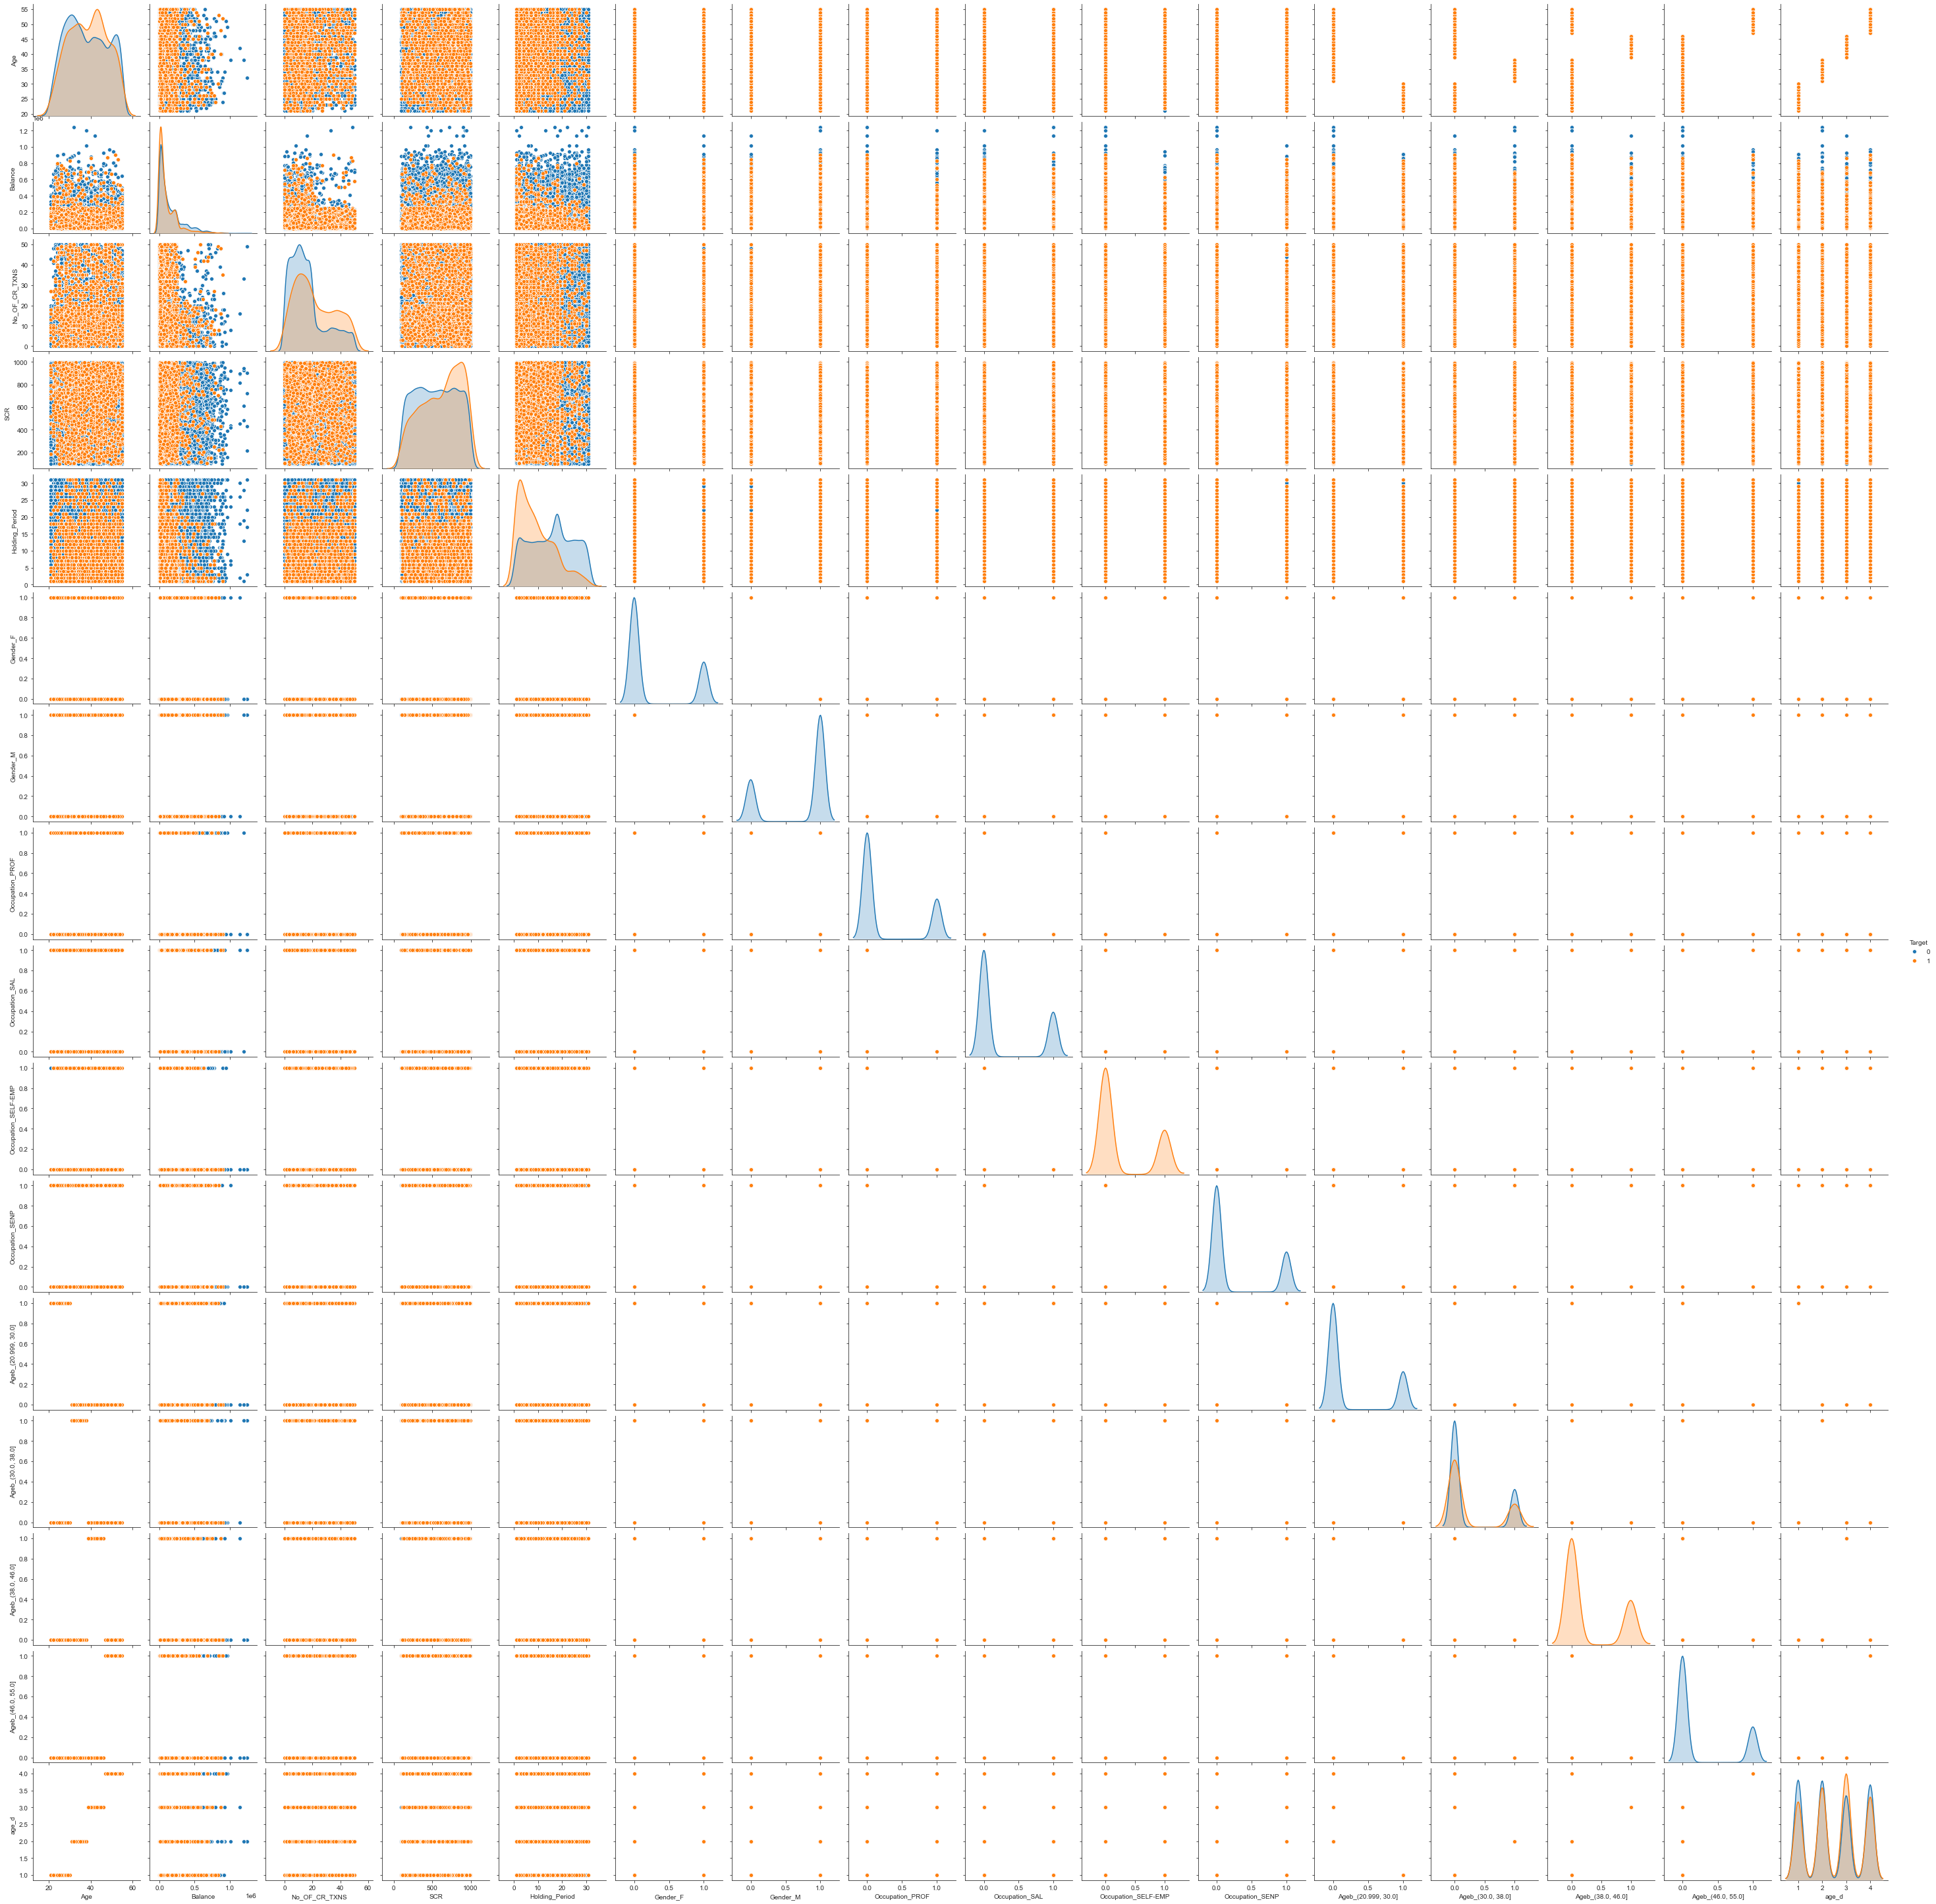

In [147]:
sns.pairplot(data1, hue = 'Target')
plt.show()

## SHAP - BlackBox Model

In [148]:
# import shap

In [149]:
# X_train_summary = shap.kmeans(X_train_orig, 10)

In [150]:
# explainerKNN = shap.KernelExplainer(clf_KNN0.predict,X_train_summary)

In [151]:
# shap_values_KNN_test = explainerKNN.shap_values(X_test_orig)

In [152]:
# shap.initjs()
# shap.force_plot(explainerKNN.expected_value, shap_values_KNN_test[:1000,:], X_test_orig.iloc[:1000,:])

## LIME- BlackBox Model

In [153]:
# import lime
# import lime.lime_tabular

In [154]:
# lgb_params = {
#   'task': 'train',
#     'boosting_type': 'goss',
#     'objective': 'binary',
#     'metric':'binary_logloss',
#     'metric': {'l2', 'auc'},
#     'num_leaves': 50,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'verbose': None,
#     'num_iteration':100,
#     'num_threads':7,
#     'max_depth':12,
#     'min_data_in_leaf':100,
#     'alpha':0.5}

In [156]:
# import warnings
# from lime import submodular_pick
# import lightgbm as lgb

# lgb_train = lgb.Dataset(X_train_orig, y_train_orig)
# lgb_eval = lgb.Dataset(X_test_orig, y_test_orig)

# model = lgb.train(lgb_params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=5)
# lime.lime_tabular.LimeTabularExplainer(data[model.feature_name()].astype(int).values,  
# mode='classification',training_labels=data3['Target'],feature_names=model.feature_name())
# # Remember to convert the dataframe to matrix values
# # SP-LIME returns exaplanations on a sample set to provide a non redundant global decision boundary of original model
# sp_obj = submodular_pick.SubmodularPick(explainer,data3[model.feature_name()].values, \
# prob, num_features=5,num_exps_desired=10)

# [exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

## CatBoost Classifier

In [157]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(random_seed=42)

In [158]:
cate_features_index = np.where(data.dtypes != float)[0]

In [159]:
X_over_train

,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_M,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP
0,42,63824,8,929,4,1,1,0,0
1,23,682406,5,550,23,0,0,0,0
2,50,468326,16,242,17,1,0,0,1
3,54,151676,4,426,19,1,0,0,0
4,31,65699,7,147,24,1,0,1,0
...,...,...,...,...,...,...,...,...,...
27137,34,245500,34,761,26,0,0,0,0
27138,36,6196,14,989,4,1,0,0,1
27139,47,121226,39,619,17,1,0,0,0
27140,41,550,38,437,11,0,0,0,0


In [160]:
model.fit(X_under_train,y_under_train,cat_features=cate_features_index)

Learning rate set to 0.015401
0:	learn: 0.6859731	total: 183ms	remaining: 3m 3s
1:	learn: 0.6784463	total: 214ms	remaining: 1m 46s
2:	learn: 0.6723886	total: 216ms	remaining: 1m 11s
3:	learn: 0.6663302	total: 243ms	remaining: 1m
4:	learn: 0.6593005	total: 251ms	remaining: 50s
5:	learn: 0.6534294	total: 260ms	remaining: 43.1s
6:	learn: 0.6478072	total: 268ms	remaining: 38s
7:	learn: 0.6425816	total: 272ms	remaining: 33.7s
8:	learn: 0.6373741	total: 275ms	remaining: 30.3s
9:	learn: 0.6315745	total: 279ms	remaining: 27.6s
10:	learn: 0.6265926	total: 283ms	remaining: 25.5s
11:	learn: 0.6217886	total: 287ms	remaining: 23.7s
12:	learn: 0.6173127	total: 291ms	remaining: 22.1s
13:	learn: 0.6128694	total: 299ms	remaining: 21s
14:	learn: 0.6084725	total: 302ms	remaining: 19.9s
15:	learn: 0.6040113	total: 306ms	remaining: 18.8s
16:	learn: 0.6003024	total: 310ms	remaining: 17.9s
17:	learn: 0.5961816	total: 318ms	remaining: 17.3s
18:	learn: 0.5932008	total: 321ms	remaining: 16.6s
19:	learn: 0.58960

185:	learn: 0.4265634	total: 1.66s	remaining: 7.25s
186:	learn: 0.4262113	total: 1.66s	remaining: 7.23s
187:	learn: 0.4261220	total: 1.67s	remaining: 7.2s
188:	learn: 0.4260820	total: 1.67s	remaining: 7.17s
189:	learn: 0.4255722	total: 1.68s	remaining: 7.15s
190:	learn: 0.4250998	total: 1.68s	remaining: 7.13s
191:	learn: 0.4249453	total: 1.69s	remaining: 7.12s
192:	learn: 0.4247367	total: 1.7s	remaining: 7.12s
193:	learn: 0.4244380	total: 1.71s	remaining: 7.1s
194:	learn: 0.4240454	total: 1.72s	remaining: 7.09s
195:	learn: 0.4236723	total: 1.72s	remaining: 7.07s
196:	learn: 0.4233730	total: 1.73s	remaining: 7.05s
197:	learn: 0.4232125	total: 1.74s	remaining: 7.03s
198:	learn: 0.4229888	total: 1.74s	remaining: 7.02s
199:	learn: 0.4227916	total: 1.75s	remaining: 7s
200:	learn: 0.4226170	total: 1.76s	remaining: 6.99s
201:	learn: 0.4222783	total: 1.76s	remaining: 6.97s
202:	learn: 0.4220643	total: 1.77s	remaining: 6.95s
203:	learn: 0.4217548	total: 1.78s	remaining: 6.95s
204:	learn: 0.4214

349:	learn: 0.3955718	total: 2.92s	remaining: 5.43s
350:	learn: 0.3953355	total: 2.93s	remaining: 5.41s
351:	learn: 0.3952450	total: 2.94s	remaining: 5.4s
352:	learn: 0.3951631	total: 2.94s	remaining: 5.39s
353:	learn: 0.3948621	total: 2.95s	remaining: 5.38s
354:	learn: 0.3947205	total: 2.95s	remaining: 5.37s
355:	learn: 0.3945597	total: 2.96s	remaining: 5.35s
356:	learn: 0.3943583	total: 2.97s	remaining: 5.35s
357:	learn: 0.3942664	total: 2.98s	remaining: 5.34s
358:	learn: 0.3940694	total: 2.98s	remaining: 5.32s
359:	learn: 0.3939364	total: 2.99s	remaining: 5.32s
360:	learn: 0.3938321	total: 2.99s	remaining: 5.3s
361:	learn: 0.3935317	total: 3s	remaining: 5.29s
362:	learn: 0.3934642	total: 3s	remaining: 5.27s
363:	learn: 0.3930423	total: 3.01s	remaining: 5.26s
364:	learn: 0.3930395	total: 3.01s	remaining: 5.24s
365:	learn: 0.3927141	total: 3.02s	remaining: 5.23s
366:	learn: 0.3925602	total: 3.03s	remaining: 5.22s
367:	learn: 0.3923860	total: 3.04s	remaining: 5.21s
368:	learn: 0.392297

540:	learn: 0.3717271	total: 4.2s	remaining: 3.57s
541:	learn: 0.3716492	total: 4.21s	remaining: 3.56s
542:	learn: 0.3714794	total: 4.22s	remaining: 3.55s
543:	learn: 0.3712880	total: 4.22s	remaining: 3.54s
544:	learn: 0.3711095	total: 4.23s	remaining: 3.53s
545:	learn: 0.3709152	total: 4.23s	remaining: 3.52s
546:	learn: 0.3708549	total: 4.24s	remaining: 3.51s
547:	learn: 0.3706109	total: 4.24s	remaining: 3.5s
548:	learn: 0.3703600	total: 4.25s	remaining: 3.49s
549:	learn: 0.3703531	total: 4.25s	remaining: 3.48s
550:	learn: 0.3701919	total: 4.25s	remaining: 3.47s
551:	learn: 0.3701846	total: 4.26s	remaining: 3.46s
552:	learn: 0.3701424	total: 4.26s	remaining: 3.44s
553:	learn: 0.3699074	total: 4.27s	remaining: 3.43s
554:	learn: 0.3696885	total: 4.27s	remaining: 3.42s
555:	learn: 0.3696141	total: 4.27s	remaining: 3.41s
556:	learn: 0.3695921	total: 4.28s	remaining: 3.4s
557:	learn: 0.3695776	total: 4.28s	remaining: 3.39s
558:	learn: 0.3695500	total: 4.29s	remaining: 3.38s
559:	learn: 0.3

712:	learn: 0.3555528	total: 5.49s	remaining: 2.21s
713:	learn: 0.3555077	total: 5.49s	remaining: 2.2s
714:	learn: 0.3552373	total: 5.5s	remaining: 2.19s
715:	learn: 0.3552282	total: 5.51s	remaining: 2.19s
716:	learn: 0.3552213	total: 5.53s	remaining: 2.18s
717:	learn: 0.3550490	total: 5.53s	remaining: 2.17s
718:	learn: 0.3548928	total: 5.54s	remaining: 2.16s
719:	learn: 0.3547396	total: 5.54s	remaining: 2.16s
720:	learn: 0.3545691	total: 5.55s	remaining: 2.15s
721:	learn: 0.3544716	total: 5.56s	remaining: 2.14s
722:	learn: 0.3542353	total: 5.57s	remaining: 2.13s
723:	learn: 0.3542173	total: 5.57s	remaining: 2.12s
724:	learn: 0.3539926	total: 5.58s	remaining: 2.12s
725:	learn: 0.3537514	total: 5.58s	remaining: 2.11s
726:	learn: 0.3536819	total: 5.59s	remaining: 2.1s
727:	learn: 0.3535622	total: 5.64s	remaining: 2.11s
728:	learn: 0.3534181	total: 5.65s	remaining: 2.1s
729:	learn: 0.3532171	total: 5.66s	remaining: 2.09s
730:	learn: 0.3531363	total: 5.66s	remaining: 2.08s
731:	learn: 0.35

894:	learn: 0.3329200	total: 6.77s	remaining: 794ms
895:	learn: 0.3328164	total: 6.77s	remaining: 786ms
896:	learn: 0.3326404	total: 6.78s	remaining: 778ms
897:	learn: 0.3324501	total: 6.8s	remaining: 772ms
898:	learn: 0.3323077	total: 6.8s	remaining: 764ms
899:	learn: 0.3322091	total: 6.81s	remaining: 756ms
900:	learn: 0.3320705	total: 6.81s	remaining: 749ms
901:	learn: 0.3318313	total: 6.82s	remaining: 741ms
902:	learn: 0.3317423	total: 6.83s	remaining: 733ms
903:	learn: 0.3315985	total: 6.83s	remaining: 725ms
904:	learn: 0.3314695	total: 6.83s	remaining: 717ms
905:	learn: 0.3313530	total: 6.84s	remaining: 710ms
906:	learn: 0.3313285	total: 6.84s	remaining: 702ms
907:	learn: 0.3313055	total: 6.85s	remaining: 694ms
908:	learn: 0.3311999	total: 6.85s	remaining: 686ms
909:	learn: 0.3311004	total: 6.86s	remaining: 678ms
910:	learn: 0.3310476	total: 6.86s	remaining: 670ms
911:	learn: 0.3308992	total: 6.86s	remaining: 662ms
912:	learn: 0.3306804	total: 6.87s	remaining: 654ms
913:	learn: 0.

In [161]:
test = pd.read_csv("test_data.csv")
pred = model.predict(test)


In [162]:
from sklearn.metrics import confusion_matrix

In [163]:
confusion_matrix(y_test_orig, pred)

array([[1799, 2725],
       [ 178,  249]], dtype=int64)

## Model Evaluation Matrix

In [221]:
model_eval = {'Good Fit Percent%': ['10.9','9.84','19.6','17.2','8.6','18.4','11.4','25.0','25.0','16.4','20.8','17.2'],
        'Comments': ['Not Considering','Not Considering','Not Considering','Not Considering','Not Considering','Not Considering',
                     'Not Considering','Considering','Considering','Not Considering','Considering','Not Considering',]
        }

df = pd.DataFrame(model_eval, columns = ['Good Fit Percent%','Comments'], index=['DecisionTreeClassifier - Original Data','DecisionTreeClassifier - UnderSampled Data','DecisionTreeClassifier - OverSampled Data',
                                                                           'KNN Classifier - Original Data','KNN Classifier - Undersampled Data','Random Forest Classifier - Original Data','RandomForest Classifier - Undersampled Data',
                                                                           'RandomForest Classifier - Oversampled Data','Logistic Regression - Original Data','Logistic Regression - Undersampled Data',
                                                                          'Logistic Regression - Oversampled Data','KNN Classifier - Oversampled Data'])

print (df)

                                            Good Fit Percent%         Comments
DecisionTreeClassifier - Original Data                   10.9  Not Considering
DecisionTreeClassifier - UnderSampled Data               9.84  Not Considering
DecisionTreeClassifier - OverSampled Data                19.6  Not Considering
KNN Classifier - Original Data                           17.2  Not Considering
KNN Classifier - Undersampled Data                        8.6  Not Considering
Random Forest Classifier - Original Data                 18.4  Not Considering
RandomForest Classifier - Undersampled Data              11.4  Not Considering
RandomForest Classifier - Oversampled Data               25.0      Considering
Logistic Regression - Original Data                      25.0      Considering
Logistic Regression - Undersampled Data                  16.4  Not Considering
Logistic Regression - Oversampled Data                   20.8      Considering
KNN Classifier - Oversampled Data                   